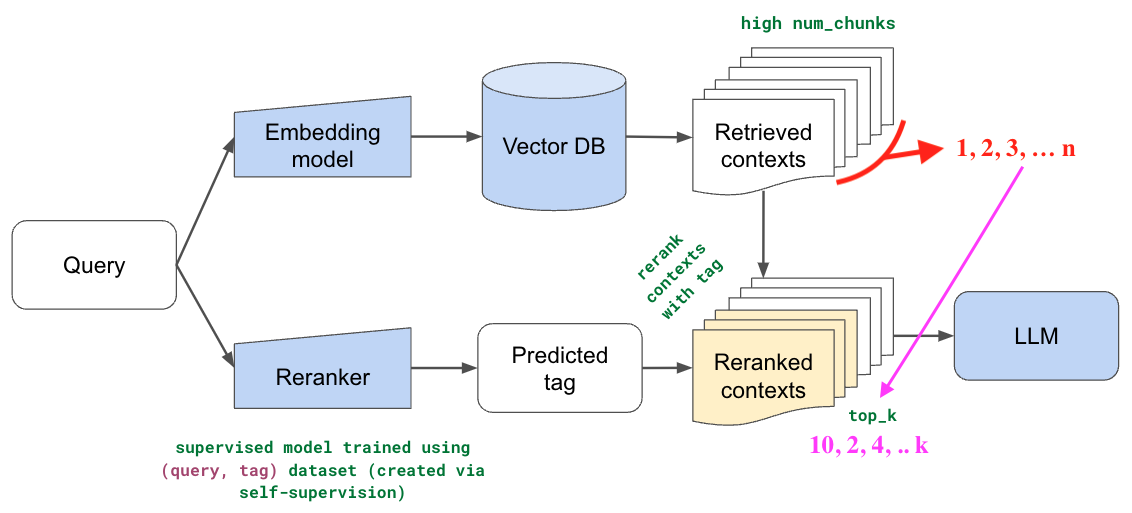

# Problem Statement:


In a typical RAG pipeline, LLM Context window is limited so for a hypothetical 10000 pages document, we need to chunk the document. For any incoming user query, we need to fetch `Top-N` related chunks and because neither our Embedding are 100% accurate nor search algo is perfect, it could give us unrelated results too. This is a flaw in RAG pipeline. How can you deal with it? If you fetch Top-1 and the context is different then it's a sure bad answer. On the other hand, if you fetch more chunks and pass to LLM, it'll get confused and with higher number, it'll go out of context.

# What's the remedy?

Out of all the methods available, Re-ranking is the simplest. Idea is pretty simple.


1. You assume that Embedding + Search algo are not 100% precise so you use Recall to your advantage and get similar high `N` (say 25) number of related chunks from corpus.

2. Second step is to use a powerful model to increase the Precision. You re-rank above `N` queries again so that you can change the relative ordering and now select Top `K` queries (say 3) to pass as a context where `K` < `N` thus increasing the Precision.


# Why can't you use the bigger model in the first place?
Would your search results be better if you were searching in 100 vs 100000 documents? Yes, so no matter how big of a model you use, you'll always have some irrelevent results because of the huge domain.


Smaller model with efficient searching algo does the work of searching in a bigger domain to get more number of elements while the larger model is precise and because it just works on `K`, there is a bit more overhead but improved relevancy.


### Installing dependencies

In [1]:
# NOTE: If there is an import error, restart and run the notebook again

!pip install -U lancedb transformers datasets FlagEmbedding unstructured langchain peft -qq

### Importing libraries

In [5]:
# All document present here https://github.com/FlagOpen/FlagEmbedding/tree/master

from FlagEmbedding import FlagAutoModel, FlagAutoReranker
import os
import lancedb
import re
import pandas as pd
import random

from datasets import load_dataset

import torch
import gc

import lance
from lancedb.embeddings import with_embeddings


task = "qa"  # Encode for a specific task (qa, icl, chat, lrlm, tool, convsearch)

# Load model (automatically use GPUs)
embed_model = FlagAutoModel.from_finetuned("BAAI/bge-base-en", use_fp16=False)

# use_fp16 speeds up computation with a slight performance degradation
reranker_model = FlagAutoReranker.from_finetuned(
    "BAAI/bge-reranker-base", use_fp16=True
)

# For basic splitting
# basic_text_splitter = RecursiveCharacterTextSplitter(chunk_size=512, chunk_overlap=64,) # 512 is the default Embedding model max_len

# For Advanced Usage: https://python.langchain.com/docs/modules/data_connection/document_transformers/text_splitters/split_by_token
# embedder_tokenizer = AutoTokenizer.from_pretrained("BAAI/llm-embedder") # Advanced Tokenizer Splitter Strategy
# advanced_text_splitter = RecursiveCharacterTextSplitter.from_huggingface_tokenizer(embedder_tokenizer, chunk_size=512, chunk_overlap=0)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/719 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/443 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/279 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/799 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

# Load `Chunks` of data from [BeIR Dataset](https://huggingface.co/datasets/BeIR/scidocs)

Note: This is a dataset built specially for retrieval tasks to see how good your search is working

In [6]:
queries = load_dataset("BeIR/scidocs", "queries")["queries"].to_pandas()
docs = (
    load_dataset("BeIR/scidocs", "corpus")["corpus"]
    .to_pandas()
    .dropna(subset="text")
    .sample(10000)
)  # just random samples for faster embed demo
docs.sample(3)

Generating queries split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Generating corpus split:   0%|          | 0/25657 [00:00<?, ? examples/s]

,_id,title,text
5180,96b95da0ab88de23641014abff2a5c0b5fec00c9,O Bitcoin Where Art Thou? Insight into Large-S...,Bitcoin is a rising digital currency and exemp...
24907,658ae58cc25748e5767ca17710c42d9b0d9061be,"Adolescents' attitudes toward sports, exercise...",OBJECTIVE\nTo determine whether adolescent att...
7380,029341c7f1ce11696a6bc7e7a716b7876010ebc7,Model Learning for Look-ahead Exploration in C...,We propose an exploration method that incorpor...


# Get embedding using [`Flag embedder`](https://github.com/FlagOpen/FlagEmbedding/tree/master/examples/inference/embedder) and create Database using [`LanceDB`](https://github.com/lancedb/lancedb)

In [9]:
def embed_documents(batch):
    """
    Function to embed the whole text data
    """
    return embed_model.encode(batch)  # Encode data or 'keys'


db = lancedb.connect("./db")  # Connect Local DB
if "doc_embed" in db.table_names():
    table = db.open_table("doc_embed")  # Open Table
else:
    # Use the train text chunk data to save embed in the DB
    data = with_embeddings(
        embed_documents, docs, column="text", show_progress=True, batch_size=128
    )
    table = db.create_table("doc_embed", data=data)  # create Table

<ipython-input-9-dea0e9da305c>:13: DeprecationWarning: Function with_embeddings is deprecated and will be removed in a future version
  data = with_embeddings(


  0%|          | 0/79 [00:00<?, ?it/s]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


# Search from a random Text

In [11]:
def search(query, top_k=10):
    """
    Search a query from the table
    """
    query_vector = embed_model.encode_queries(
        query
    )  # Encode the QUERY (it is done differently than the 'key')
    search_results = table.search(query_vector).limit(top_k)
    return search_results


query = random.choice(queries["text"])
print("QUERY:-> ", query)

# get top_k search results
search_results = (
    search("what is mitochondria?", top_k=10)
    .to_pandas()
    .dropna(subset="text")
    .reset_index(drop=True)
)

search_results

QUERY:->  Survey on modeling and indexing events in multimedia


,_id,title,text,vector,_distance
0,a3345798b1faf238e8d805bbe9124b0b8e0c869f,Autophagy as a regulated pathway of cellular d...,Macroautophagy is a dynamic process involving ...,"[-0.046249095, -0.014331797, -0.014212782, 0.0...",0.407326
1,55f0f716a355adc7e29593bf650590b1a5a552b5,Cell biology of protein misfolding: The exampl...,The salutary intersection of fundamental cell ...,"[-0.042478364, -0.009552156, -0.02134558, -0.0...",0.427390
2,83d323a5bb26b706d4f6d24eb27411a7e7ff57e6,Protective action of green tea catechins in ne...,Mitochondria are central players in the regula...,"[-0.021206858, 0.0051165842, -0.029477177, -0....",0.442935
3,4ebebbb6d64c8abdff7a2a721db6f40002a2cd5b,Computational systems biology,To understand complex biological systems requi...,"[-0.0032612674, 0.008874702, -0.013688106, 0.0...",0.443544
4,5f0806351685bd999699399ea9553c91733ccb7d,Handwritten document image segmentation into t...,Article history: Received 22 July 2008 Receive...,"[0.012142083, 0.016298598, -0.014467204, -0.00...",0.447429
5,7fdf8e2393ee280c9a3aeb94aae375411358e45a,Real-time traffic sign recognition from video ...,Article history: Received 1 August 2007 Receiv...,"[0.02087315, 0.018889982, -0.009222908, -0.011...",0.449620
6,d31798506874705f900e72203515abfaa9278409,Off-line recognition of realistic Chinese hand...,Article history: Received 26 August 2007 Recei...,"[0.010442879, 0.018291468, -0.012523484, 0.000...",0.449889
7,2c13b73ce6123966a9f8c82b8f26d9e3fbc312b7,The biology of cancer: metabolic reprogramming...,"Cell proliferation requires nutrients, energy,...","[-0.024636492, -0.012112032, -0.0029014363, -0...",0.453977
8,dcd72f0a9cdc37450379f401fc2f4f87e30f5021,Social Software in Higher Education: The Diver...,,"[0.013944653, 0.012008667, -0.0057341345, -0.0...",0.455767
9,bca4e05a45f310ceb327d67278858343e8df7089,Improved churn prediction in telecommunication...,,"[0.013944653, 0.012008667, -0.0057341345, -0.0...",0.455767


# Rerank Search Results using Reranker from [`BGE Reranker`](https://github.com/FlagOpen/FlagEmbedding/tree/master/examples/inference/reranker)

Pass all the results to a stronger model to give them the similarity ranking

In [12]:
def rerank(query, search_results):
    search_results["old_similarity_rank"] = search_results.index + 1  # Old ranks

    torch.cuda.empty_cache()
    gc.collect()

    search_results["new_scores"] = reranker_model.compute_score(
        [[query, chunk] for chunk in search_results["text"]]
    )  # Re compute ranks
    return search_results.sort_values(by="new_scores", ascending=False).reset_index(
        drop=True
    )


print("QUERY:-> ", query)

rerank(query, search_results)

QUERY:->  Survey on modeling and indexing events in multimedia


pre tokenize: 100%|██████████| 1/1 [00:00<00:00, 117.87it/s]
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2888: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


,_id,title,text,vector,_distance,old_similarity_rank,new_scores
0,dcd72f0a9cdc37450379f401fc2f4f87e30f5021,Social Software in Higher Education: The Diver...,,"[0.013944653, 0.012008667, -0.0057341345, -0.0...",0.455767,9,-5.273438
1,bca4e05a45f310ceb327d67278858343e8df7089,Improved churn prediction in telecommunication...,,"[0.013944653, 0.012008667, -0.0057341345, -0.0...",0.455767,10,-5.273438
2,4ebebbb6d64c8abdff7a2a721db6f40002a2cd5b,Computational systems biology,To understand complex biological systems requi...,"[-0.0032612674, 0.008874702, -0.013688106, 0.0...",0.443544,4,-5.761719
3,a3345798b1faf238e8d805bbe9124b0b8e0c869f,Autophagy as a regulated pathway of cellular d...,Macroautophagy is a dynamic process involving ...,"[-0.046249095, -0.014331797, -0.014212782, 0.0...",0.407326,1,-8.546875
4,2c13b73ce6123966a9f8c82b8f26d9e3fbc312b7,The biology of cancer: metabolic reprogramming...,"Cell proliferation requires nutrients, energy,...","[-0.024636492, -0.012112032, -0.0029014363, -0...",0.453977,8,-9.054688
5,5f0806351685bd999699399ea9553c91733ccb7d,Handwritten document image segmentation into t...,Article history: Received 22 July 2008 Receive...,"[0.012142083, 0.016298598, -0.014467204, -0.00...",0.447429,5,-9.460938
6,d31798506874705f900e72203515abfaa9278409,Off-line recognition of realistic Chinese hand...,Article history: Received 26 August 2007 Recei...,"[0.010442879, 0.018291468, -0.012523484, 0.000...",0.449889,7,-9.460938
7,7fdf8e2393ee280c9a3aeb94aae375411358e45a,Real-time traffic sign recognition from video ...,Article history: Received 1 August 2007 Receiv...,"[0.02087315, 0.018889982, -0.009222908, -0.011...",0.449620,6,-9.734375
8,55f0f716a355adc7e29593bf650590b1a5a552b5,Cell biology of protein misfolding: The exampl...,The salutary intersection of fundamental cell ...,"[-0.042478364, -0.009552156, -0.02134558, -0.0...",0.427390,2,-10.070312
9,83d323a5bb26b706d4f6d24eb27411a7e7ff57e6,Protective action of green tea catechins in ne...,Mitochondria are central players in the regula...,"[-0.021206858, 0.0051165842, -0.029477177, -0....",0.442935,3,-10.195312
